In [1]:
#using Pkg
#Pkg.add("Distributions")

In [2]:
using Distributions
using Plots
default(fmt=:png)
safediv(x, y) = x == 0 ? zero(x/y) : x/y

function pvalue_binomial_clopper_pearson(k, n, p; alt=:twosided)
    @assert alt in (:twosided, :greater, :less)
    bin = Binomial(n, p)
    if alt == :twosided
        min(1, 2ccdf(bin, k-1), 2cdf(bin, k))
    elseif alt == :greater
        ccdf(bin, k-1)
    elseif alt == :less
        cdf(bin, k)
    end
end

function confint_binomial_clopper_pearson(k, n, alpha; alt=:twosided)
    @assert alt in (:twosided, :greater, :less)
    _alpha = alt == :twosided ? alpha/2 : alpha
    L = k > 0 ? quantile(Beta(k, n-k+1), _alpha) : zero(_alpha)
    U = k < n ? cquantile(Beta(k+1, n-k), _alpha) : one(_alpha)
    if alt == :twosided
        [L, U]
    elseif alt == :greater
        [L, 1]
    elseif alt == :less
        [0, U]
    end
end

function binomial_clopper_pearson_test(k, n; p=0.5, alpha=0.05, alt=:twosided)
    pvalue = pvalue_binomial_clopper_pearson(k, n, p; alt)
    confint = confint_binomial_clopper_pearson(k, n, alpha; alt)
    (; pvalue, confint)
end

function pvalue_binomial_wald(k, n, p; alt=:twosided)
    @assert alt in (:twosided, :greater, :less)
    phat = k/n
    z = safediv(phat - p, sqrt(phat*(1 - phat)/n))
    if alt == :twosided
        2ccdf(Normal(), abs(z))
    elseif alt == :greater
        ccdf(Normal(), z)
    elseif alt == :less
        cdf(Normal(), z)
    end
end

function confint_binomial_wald(k, n, alpha; alt=:twosided)
    @assert alt in (:twosided, :greater, :less)
    phat = k/n
    sehat = sqrt(phat*(1 - phat)/n)
    w = cquantile(Normal(), alt == :twosided ? alpha/2 : alpha)
    L, U = phat - w*sehat, phat + w*sehat
    if alt == :twosided
        [L, U]
    elseif alt == :greater
        [L, 1]
    elseif alt == :less
        [0, U]
    end
end

function pvalue_binomial_score(k, n, p; alt=:twosided)
    @assert alt in (:twosided, :greater, :less)
    phat = k/n
    z = safediv(phat - p, sqrt(p*(1 - p)/n))
    if alt == :twosided
        2ccdf(Normal(), abs(z))
    elseif alt == :greater
        ccdf(Normal(), z)
    elseif alt == :less
        cdf(Normal(), z)
    end
end

function binomial_wald_test(k, n; p=0.5, alpha=0.05, alt=:twosided)
    pvalue = pvalue_binomial_wald(k, n, p; alt)
    confint = confint_binomial_wald(k, n, alpha; alt)
    (; pvalue, confint)
end

function confint_binomial_score(k, n, alpha; alt=:twosided)
    @assert alt in (:twosided, :greater, :less)
    alpha ≥ 1 && return [0.0, 1.0]
    phat = k/n
    w = cquantile(Normal(), alt == :twosided ? alpha/2 : alpha)
    A, B, C = 1 + w^2/n, phat + w^2/(2n), phat^2
    sqrtD = sqrt(B^2 - A*C)
    L, U = (B - sqrtD)/A, (B + sqrtD)/A
    if alt == :twosided
        [L, U]
    elseif alt == :greater
        [L, 1]
    elseif alt == :less
        [0, U]
    end
end

function binomial_socre_test(k, n; p=0.5, alpha=0.05, alt=:twosided)
    pvalue = pvalue_binomial_score(k, n, p; alt)
    confint = confint_binomial_score(k, n, alpha; alt)
    (; pvalue, confint)
end

function plot_binomial_score_pvalue_functions_1x2(; k=42, n=50, p=0.7, alpha=0.05)
    @show k n p alpha
    println("alt=:greater  -> ", binomial_socre_test(k, n; p, alpha=alpha/2, alt=:greater))
    println("alt=:less     -> ", binomial_socre_test(k, n; p, alpha=alpha/2, alt=:less))
    println("alt=:twosided -> ", binomial_socre_test(k, n; p, alpha, alt=:twosided))

    P = plot()
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:greater), 0, 1; label="P-values for alt=:greater")
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:less), 0, 1; label="P-values for alt=:less")
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:twosided)/2, 0, 1; label="half of P-values for alt=:twosided", ls=:dash)
    plot!(legend=:left)
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    plot!(xguide="p")

    Q = plot()
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:twosided), 0, 1; label="P-values for alt=:twosided", c=3)
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    plot!(xguide="p")

    plot(P, Q; size=(1000, 340), legendfontsize=11, bottommargin=6Plots.mm)
    plot!(plot_title="data: k=$k out of n=$n")
end

function plot_binomial_score_pvalue_functions_2x2(; k=42, n=50, p=0.7, alpha=0.05,
        l=[:left, :left, true, :left])
    @show k n p alpha
    println("alt=:greater  -> ", binomial_socre_test(k, n; p, alpha=alpha/2, alt=:greater))
    println("alt=:less     -> ", binomial_socre_test(k, n; p, alpha=alpha/2, alt=:less))
    println("alt=:twosided -> ", binomial_socre_test(k, n; p, alpha, alt=:twosided))

    ci = confint_binomial_score(k, n, alpha/2; alt=:greater)
    P = plot()
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:greater), 0, 1;
        label="P-values for alt=:greater", c=1)
    plot!(ci, fill(alpha/2, 2);
        label="97.5% confidence interval for alt=:greater", c=1, ls=:dot, lw=2)
    plot!(legend=l[1])
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    plot!(xguide="p")
    annotate!(mean(ci), 0.1, text("height\n0.025", :center, palette(:default)[1], 10))

    ci = confint_binomial_score(k, n, alpha/2; alt=:less)
    Q = plot()
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:less), 0, 1;
        label="P-values for alt=:less", c=2)
    plot!(ci, fill(alpha/2, 2);
        label="97.5% confidence interval for alt=:less", c=2, ls=:dot, lw=2)
    plot!(legend=l[2])
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    plot!(xguide="p")
    annotate!(mean(ci), 0.1, text("height\n0.025", :center, palette(:default)[2], 10))

    ci = confint_binomial_score(k, n, alpha; alt=:twosided)
    R = plot()
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:twosided), 0, 1;
        label="P-values for alt=:twosided", c=3)
    plot!(ci, fill(alpha, 2);
        label="95% confidence interval for alt=:twosided", c=3, ls=:dot, lw=2)
    plot!(legend=l[3])
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    plot!(xguide="p")
    annotate!(mean(ci), 0.12, text("height\n0.05", :center, palette(:default)[3], 10))

    S = plot()
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:greater), 0, 1;
        label="P-values for alt=:greater", c=1)
    plot!(confint_binomial_score(k, n, alpha/2; alt=:greater), fill(alpha/2+0.005, 2);
        label="97.5% confidence interval for alt=:greater", c=1, ls=:dot, lw=2)
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:less), 0, 1;
        label="P-values for alt=:less", c=2)
    plot!(confint_binomial_score(k, n, alpha/2; alt=:less), fill(alpha/2-0.005, 2);
        label="97.5% confidence interval for alt=:less", c=2, ls=:dot, lw=2)
    plot!(p -> pvalue_binomial_score(k, n, p; alt=:twosided)/2, 0, 1;
        label="half of P-values for alt=:twosided", c=3, ls=:dash)
    plot!(confint_binomial_score(k, n, alpha; alt=:twosided), fill(alpha/2, 2);
        label="95% confidence interval for alt=:twosided", c=3, ls=:dot, lw=2)
    plot!(legend=l[4])
    plot!(xtick=0:0.1:1, ytick=0:0.1:1)
    plot!(xguide="p")

    plot(P, Q, R, S; size=(1000, 800), layout=(2, 2))
    plot!(plot_title="data: k=$k out of n=$n")
    plot!(legendfontsize=9)
end

plot_binomial_score_pvalue_functions_2x2 (generic function with 1 method)

https://x.com/utaka233/status/1910311534833889602

```R
> prop.test(x=42, n=50, p=0.7, alt="greater", correct=FALSE, conf.level=0.975)
```
```
	1-sample proportions test without continuity correction

data:  42 out of 50, null probability 0.7
X-squared = 4.6667, df = 1, p-value = 0.01538
alt hypothesis: true p is greater than 0.7
97.5 percent confidence interval:
 0.7148578 1.0000000
sample estimates:
   p 
0.84 
```

```R
> prop.test(x=42, n=50, p=0.7, alt="less", correct=FALSE, conf.level=0.975)
```
```
	1-sample proportions test without continuity correction

data:  42 out of 50, null probability 0.7
X-squared = 4.6667, df = 1, p-value = 0.9846
alt hypothesis: true p is less than 0.7
97.5 percent confidence interval:
 0.0000000 0.9166258
sample estimates:
   p 
0.84 
```

```R
> prop.test(x=42, n=50, p=0.7, alt="two.sided", correct=FALSE, conf.level=0.95)
```
```
	1-sample proportions test without continuity correction

data:  42 out of 50, null probability 0.7
X-squared = 4.6667, df = 1, p-value = 0.03075
alt hypothesis: true p is not equal to 0.7
95 percent confidence interval:
 0.7148578 0.9166258
sample estimates:
   p 
0.84 
```

In [3]:
k, n, p = 42, 50, 0.7
@show binomial_clopper_pearson_test(k, n; p)
@show binomial_wald_test(k, n; p)
@show binomial_socre_test(k, n; p);

binomial_clopper_pearson_test(k, n; p) = (pvalue = 0.03650669351626828, confint = [0.7088736934048891, 0.9282992328167139])
binomial_wald_test(k, n; p) = (pvalue = 0.006927517977226507, confint = [0.7383838531038208, 0.9416161468961791])
binomial_socre_test(k, n; p) = (pvalue = 0.030753561259274538, confint = [0.7148578393696495, 0.9166257932196662])


k = 42
n = 50
p = 0.7
alpha = 0.05
alt=:greater  -> (pvalue = 0.015376780629637269, confint = [0.7148578393696495, 1.0])
alt=:less     -> (pvalue = 0.9846232193703627, confint = [0.0, 0.9166257932196662])
alt=:twosided -> (pvalue = 0.030753561259274538, confint = [0.7148578393696495, 0.9166257932196662])


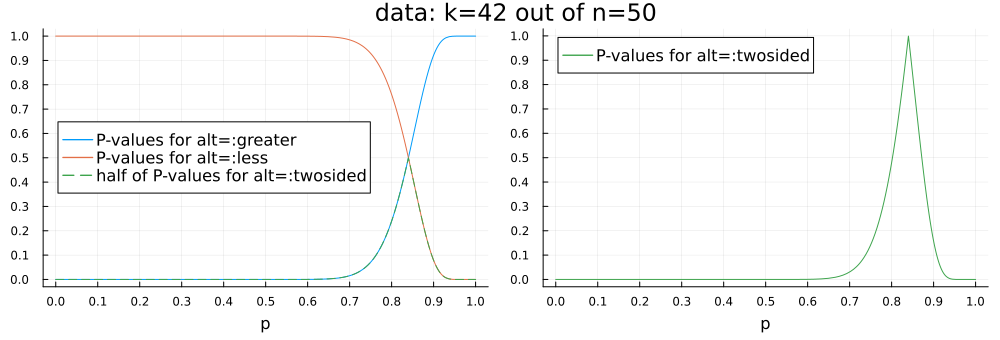

In [4]:
plot_binomial_score_pvalue_functions_1x2(; k=42, n=50, p=0.7, alpha=0.05)

k = 42
n = 50
p = 0.7
alpha = 0.05
alt=:greater  -> (pvalue = 0.015376780629637269, confint = [0.7148578393696495, 1.0])
alt=:less     -> (pvalue = 0.9846232193703627, confint = [0.0, 0.9166257932196662])
alt=:twosided -> (pvalue = 0.030753561259274538, confint = [0.7148578393696495, 0.9166257932196662])


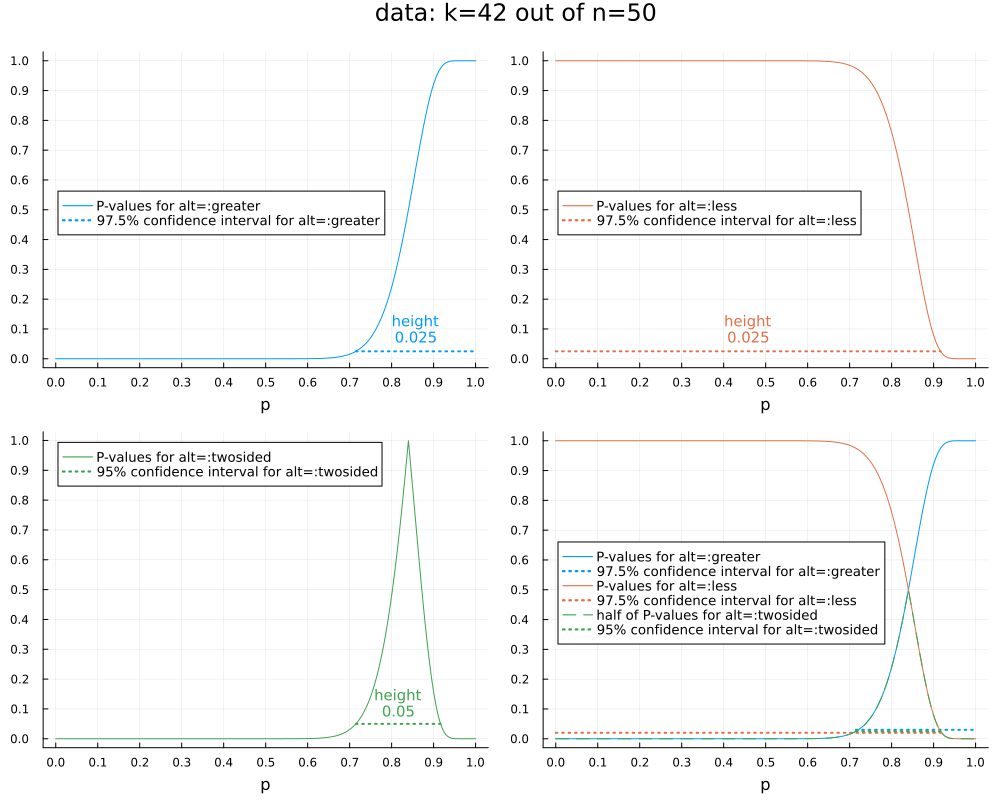

In [5]:
plot_binomial_score_pvalue_functions_2x2(; k=42, n=50, p=0.7, alpha=0.05)

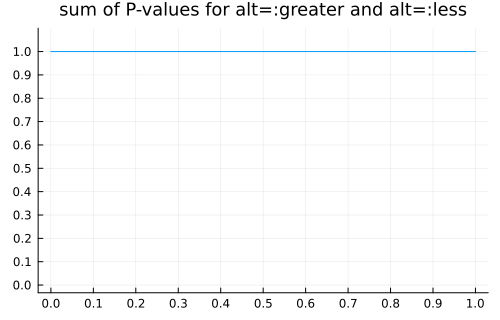

In [6]:
k, n = 42, 50
f(p) = pvalue_binomial_score(k, n, p; alt=:greater) + pvalue_binomial_score(k, n, p; alt=:less)
plot(f, 0, 1; label="", title="sum of P-values for alt=:greater and alt=:less")
plot!(ylim=(-0.033, 1.1))
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(size=(500, 320), titlefontsize=12)

k = 42
n = 50
p = 0.7
alpha = 0.05
binomial_socre_test(k, n; p, alpha = alpha / 2, alt = :greater) = (pvalue = 0.015376780629637269, confint = [0.7148578393696495, 1.0])
binomial_socre_test(k, n; p, alpha = alpha / 2, alt = :less) = (pvalue = 0.9846232193703627, confint = [0.0, 0.9166257932196662])
binomial_socre_test(k, n; p, alpha, alt = :twosided) = (pvalue = 0.030753561259274538, confint = [0.7148578393696495, 0.9166257932196662])


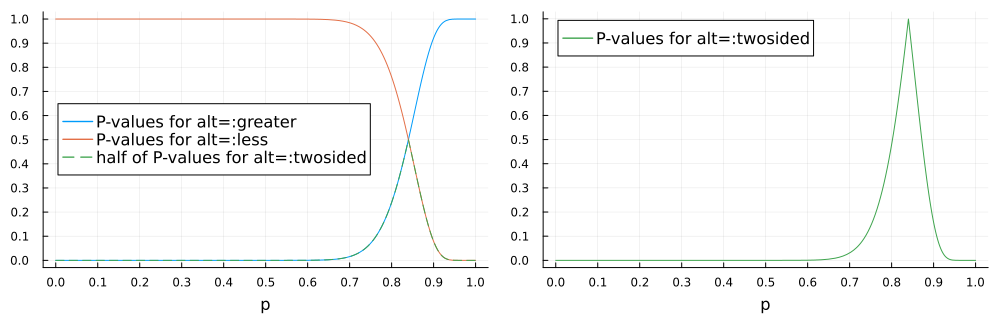

In [7]:
k, n, p, alpha = 42, 50, 0.7, 0.05
@show k n p alpha
@show binomial_socre_test(k, n; p, alpha=alpha/2, alt=:greater)
@show binomial_socre_test(k, n; p, alpha=alpha/2, alt=:less)
@show binomial_socre_test(k, n; p, alpha, alt=:twosided)

P = plot()
plot!(p -> pvalue_binomial_score(k, n, p; alt=:greater), 0, 1; label="P-values for alt=:greater")
plot!(p -> pvalue_binomial_score(k, n, p; alt=:less), 0, 1; label="P-values for alt=:less")
plot!(p -> pvalue_binomial_score(k, n, p; alt=:twosided)/2, 0, 1; label="half of P-values for alt=:twosided", ls=:dash)
plot!(legend=:left)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="p")

Q = plot()
plot!(p -> pvalue_binomial_score(k, n, p; alt=:twosided), 0, 1; label="P-values for alt=:twosided", c=3)
plot!(xtick=0:0.1:1, ytick=0:0.1:1)
plot!(xguide="p")

plot(P, Q; size=(1000, 320), legendfontsize=11, bottommargin=6Plots.mm)

In [8]:
k, n, p = 80, 192, 0.5
@show binomial_clopper_pearson_test(k, n; p)
@show binomial_wald_test(k, n; p)
@show binomial_socre_test(k, n; p);

binomial_clopper_pearson_test(k, n; p) = (pvalue = 0.025016096927259403, confint = [0.3461048011362944, 0.4898427434770385])
binomial_wald_test(k, n; p) = (pvalue = 0.019172484755223103, confint = [0.34693175537279175, 0.4864015779605416])
binomial_socre_test(k, n; p) = (pvalue = 0.020921335337794042, confint = [0.3492343227074965, 0.4873682016369625])


k = 80
n = 192
p = 0.5
alpha = 0.05
alt=:greater  -> (pvalue = 0.989539332331103, confint = [0.3492343227074965, 1.0])
alt=:less     -> (pvalue = 0.010460667668897021, confint = [0.0, 0.4873682016369625])
alt=:twosided -> (pvalue = 0.020921335337794042, confint = [0.3492343227074965, 0.4873682016369625])


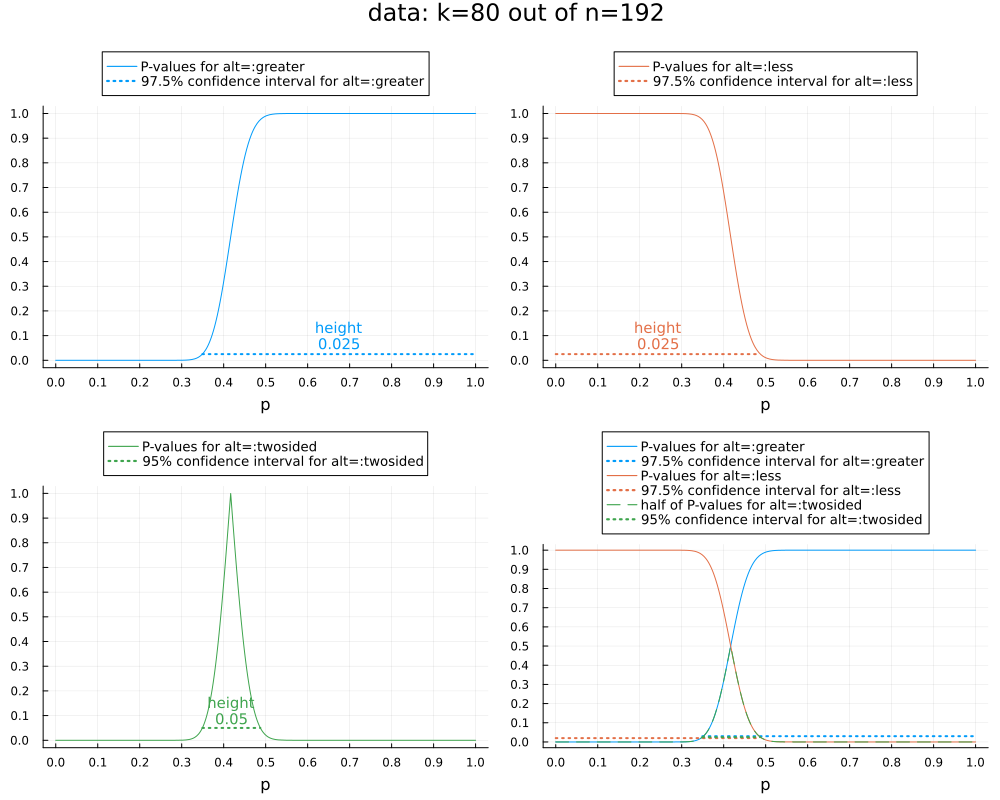

In [9]:
plot_binomial_score_pvalue_functions_2x2(; k=80, n=192, p=0.5, alpha=0.05, l=fill(:outertop, 4))